In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import random
import time

# Inside the /Multimodal-Deep-Regression/notebooks
import sys
sys.path.append("..")

from util.utilities import train, evaluate, get_device
from util.data_utilities import get_base_tensor_directories, generate_batch, get_train_and_val_loader

# import all the models from models module
from models import CNN3D

In [2]:
# Current Path
os.getcwd()

'/home/louis/Documents/gatech/Summer2023/Multimodal-Deep-Regression/notebooks'

In [3]:
device = get_device()
x_dir, y_dir = get_base_tensor_directories(input_type='video_pack_1000')

x_files = sorted([os.path.join(x_dir, f) for f in os.listdir(x_dir)])
y_files = sorted([os.path.join(y_dir, f) for f in os.listdir(y_dir)])

# load all tensors
x_data = [torch.load(f) for f in x_files]
y_data = [torch.load(f) for f in y_files]

You are using device: cuda


In [4]:
# discard single frame tensor
x_data_filtered = []
y_data_filtered = []

for x, y in zip(x_data, y_data):
    # if the third d is 2 or more
    if x.size(1) >= 2:
        x_data_filtered.append(x)
        y_data_filtered.append(y)

# replace
x_data = x_data_filtered
y_data = y_data_filtered

In [5]:
# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)
print(x_train[0].size())
print(x_val[0].size())
print(len(y_train))
print(len(y_val))

torch.Size([3, 3, 128, 72])
torch.Size([3, 14, 128, 72])
79
20


In [6]:
# Create Batches with DataLoaders
batch_size = 20
train_loader = list(zip(x_train, y_train)) #TensorDataset(x_train, y_train)
val_loader = list(zip(x_val, y_val)) #TensorDataset(x_val, y_val)
train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
val_loader = DataLoader(val_loader, batch_size=batch_size, shuffle=False, collate_fn=generate_batch)

In [7]:
model = CNN3D(shrink=8)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")

Total parameters: 148,769


In [8]:
EPOCHS = 100
train_losses = []
val_losses = []
start_time = time.time()

for epoch in range(EPOCHS):
    train_loss, avg_train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, avg_val_loss = evaluate(model, val_loader, criterion, device)
    
    # record the losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # print every num times epoch only
    num = 10
    if ((epoch+1) % num == 0) or epoch == 0:
        if epoch == 0:
            time_took = (time.time() - start_time) / 60
            print(f'First epoch took {time_took:.1f} minutes.')
        print(f'Epoch {epoch+1}/{EPOCHS}, Train_Loss: {train_loss:.2f}, Avg: {avg_train_loss:.2f}; Val_Loss: {val_loss:.2f}, Avg: {avg_val_loss:.2f}')


First epoch took 0.0 minutes.
Epoch 1/100, Train_Loss: 606480664.00, Avg: 151620166.00; Val_Loss: 24462960.00, Avg: 24462960.00
Epoch 10/100, Train_Loss: 530652711.00, Avg: 132663177.75; Val_Loss: 23649862.00, Avg: 23649862.00
Epoch 20/100, Train_Loss: 488386518.00, Avg: 122096629.50; Val_Loss: 25674906.00, Avg: 25674906.00
Epoch 30/100, Train_Loss: 471022844.00, Avg: 117755711.00; Val_Loss: 26144080.00, Avg: 26144080.00
Epoch 40/100, Train_Loss: 438536966.00, Avg: 109634241.50; Val_Loss: 24989706.00, Avg: 24989706.00
Epoch 50/100, Train_Loss: 479536742.00, Avg: 119884185.50; Val_Loss: 26866432.00, Avg: 26866432.00
Epoch 60/100, Train_Loss: 453539578.00, Avg: 113384894.50; Val_Loss: 27776986.00, Avg: 27776986.00
Epoch 70/100, Train_Loss: 420823282.00, Avg: 105205820.50; Val_Loss: 24799048.00, Avg: 24799048.00
Epoch 80/100, Train_Loss: 418745218.00, Avg: 104686304.50; Val_Loss: 24622886.00, Avg: 24622886.00
Epoch 90/100, Train_Loss: 428141090.00, Avg: 107035272.50; Val_Loss: 25626326.00

In [9]:
train_losses[-1],val_losses[-1]

(103426715.0, 25942462.0)

In [10]:
# save model if better or not exists
model_weights = {'model_state_dict': model.state_dict(), 'val_loss': avg_val_loss}
weights_file = '../models/save/CNN_weights22.pt'
if not os.path.isfile(weights_file):
    # save new
    torch.save(model_weights, weights_file)
elif model_weights['val_loss'] < torch.load(weights_file)['val_loss']:
    # replace
    torch.save(model_weights, weights_file)

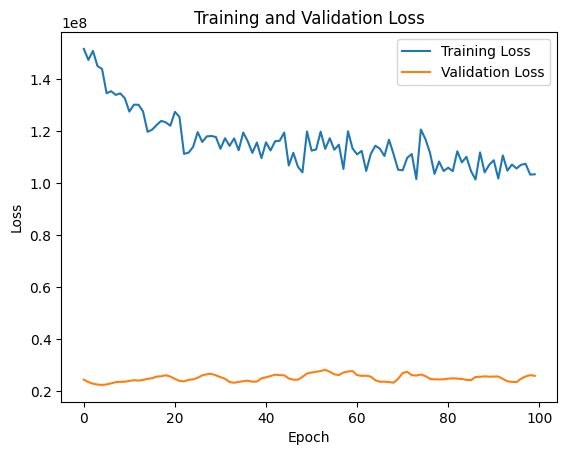

In [11]:
import matplotlib.pyplot as plt

# lost plot
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [12]:
# compare to validation set
val_values = []
predicted_values = []

for inputs, targets in val_loader:
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs).detach()

    # Append the values
    val_values.extend(targets.squeeze().long().tolist())
    predicted_values.extend(outputs.squeeze().long().tolist())

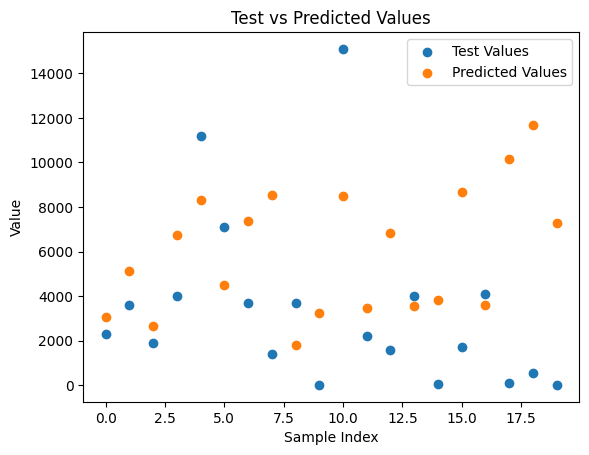

In [13]:
import matplotlib.pyplot as plt

plt.scatter(range(len(val_values)), val_values, label='Test Values')
plt.scatter(range(len(predicted_values)), predicted_values, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Test vs Predicted Values')
plt.legend()
plt.show()

In [14]:
val_values[:5], predicted_values[:5]

([2300, 3600, 1900, 4000, 11200], [3069, 5134, 2640, 6731, 8310])